In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors

# Read data

In [2]:
df_model_res = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_model_results_predict_aih_with_aps_imed.parquet')


In [3]:
df_model_res.describe()

,co_imed,pseudo_R2,log_likelihood,deviance,pearson_chi2,corre_forecasted,p_value_corr_forecast,Intercept,aih_4_lag_1,phc_4_lag_0,phc_4_lag_1,time_trend,Reconstructed
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,5.100000e+02,5.100000e+02,510.000000,510.000000,30.000000,34.000000,41.000000
mean,318584.927451,0.175635,-229.848480,12.465524,5.231991,0.890928,2.183155e-03,8.594613e-02,0.144487,0.208183,0.113532,0.471998,0.553481
std,107111.540821,0.040398,48.834382,3.720267,0.913622,0.123436,3.225030e-02,2.102591e-01,0.149414,0.137179,0.048196,0.222705,0.287648
min,110001.000000,0.062237,-467.861340,4.803425,3.429026,-0.522505,2.214846e-26,1.624950e-43,0.000048,0.001199,0.002422,0.040962,0.020400
25%,240007.250000,0.149386,-258.524271,9.907834,4.651904,0.875933,9.145381e-16,2.470682e-06,0.032610,0.106942,0.078381,0.332335,0.360081
50%,310039.500000,0.169210,-226.806830,12.070584,5.105292,0.922589,4.213372e-13,6.256047e-04,0.102961,0.183185,0.124407,0.462135,0.594926
75%,410021.750000,0.194314,-198.423090,14.603030,5.676098,0.950669,2.314658e-10,3.128447e-02,0.202137,0.283060,0.149693,0.621171,0.771854
max,530001.000000,0.413385,-94.790230,29.875294,11.882645,0.991546,7.022872e-01,9.978347e-01,0.982645,0.813648,0.188712,0.859872,0.977644


# Map variables

In [4]:
# Load shapefile of immediate regions (you need to download this from IBGE)
shapefile_path = '/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RG2017_rgi_20180911/RG2017_rgi.shp'  # update with actual file
gdf = gpd.read_file(shapefile_path)

# Make sure 'co_imed' in both files is string for easier merge
gdf['co_imed'] = gdf['rgi']  # Adjust if the column is different in your file
gdf['co_imed'] = gdf['co_imed'].astype(str)

data = df_model_res
data['co_imed'] = data['co_imed'].astype(str)

# Merge the shapefile with your data
gdf = gdf.merge(data, on='co_imed', how='left')


In [18]:
gdf['phc_4_lag_1'] =  gdf['phc_4_lag_1'].fillna(0.6)

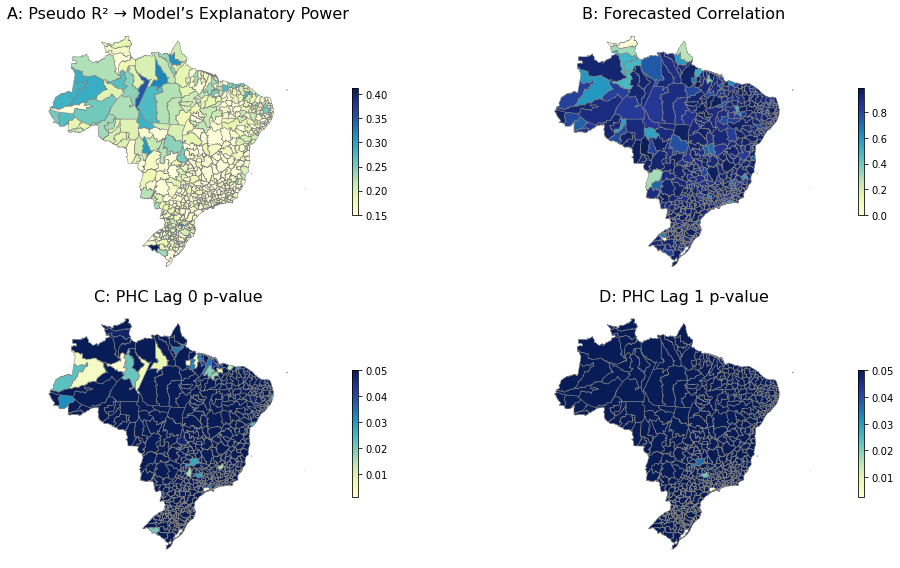

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

# Plot 1 - Pseudo R²
gdf.plot(column='pseudo_R2',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[0, 0],  # Fix index
         edgecolor='gray',
         legend=True,
         vmin= 0.15,
         legend_kwds={'shrink': 0.5}
         )
ax[0, 0].set_title('A: Pseudo R² → Model’s Explanatory Power', fontsize=16)
ax[0, 0].axis('off')

# Plot 2 - Forecasted Correlation
gdf.plot(column='corre_forecasted',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[0, 1],  # Fix index
         edgecolor='gray',
         legend=True,
         vmin= 0,
         legend_kwds={'shrink': 0.5}
         )
ax[0, 1].set_title('B: Forecasted Correlation', fontsize=16)
ax[0, 1].axis('off')

# Plot 3 - PHC Lag 0
gdf.plot(column='phc_4_lag_0',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[1, 0],  # Fix index
         edgecolor='gray',
         legend=True,
         vmax= 0.05,
         legend_kwds={'shrink': 0.5}
         )
ax[1, 0].set_title('C: PHC Lag 0 p-value', fontsize=16)
ax[1, 0].axis('off')

# Plot 4 - Hospitalization Incidence (assuming correct column)
gdf.plot(column='phc_4_lag_1',  # Change column if needed
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[1, 1],  # Fix index
         edgecolor='gray',
         legend=True,
         vmax= 0.05,
         legend_kwds={'shrink': 0.5}
         )
ax[1, 1].set_title('D: PHC Lag 1 p-value', fontsize=16)
ax[1, 1].axis('off')

# Adjust spacing
plt.tight_layout()

# Save plots if needed
# plt.savefig('map_aih_otc_aps.png', dpi=300, bbox_inches='tight')
# plt.savefig('map_aih_otc_aps.pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [26]:
# Timing 

df_time_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_aps_aih.parquet')

df_time_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_otc_aih.parquet')

In [30]:
# Create a dictionary to map old names to new names
rename_dict = {col: col + '_otc' for col in df_time_otc.columns}

# Apply renaming to the DataFrame (assuming df is your DataFrame)
df_time_otc = df_time_otc.rename(columns=rename_dict)

In [32]:
df_time_otc = df_time_otc.rename(columns = {'co_imed_otc': 'co_imed'})

In [35]:
df_time_aps.columns

Index(['co_imed', 'n3', 'n2', 'n1', 'n0', 'n1_after', 'missed',
       'total_aih_warning'],
      dtype='object')

In [37]:
dta1 = df_time_otc.merge(df_time_aps[['co_imed', 'n3', 'n2', 'n1', 'n0', 'n1_after', 'missed']], on = 'co_imed', how = 'left')

In [41]:
dta1['co_imed'] = dta1['co_imed'].astype(str)

In [43]:
gdf = gdf.merge(dta1, on = 'co_imed', how = 'left')

In [45]:
dta1

,co_imed,n3_otc,n2_otc,n1_otc,n0_otc,n1_after_otc,missed_otc,total_aih_warning_otc,n3,n2,n1,n0,n1_after,missed
0,120003,0,1,0,0,0,0,1,0,0,0,0,1,0
1,120004,2,1,0,0,1,2,6,0,0,0,1,1,4
2,270002,0,0,1,1,1,1,4,1,1,0,1,0,1
3,130007,1,0,0,0,0,0,1,0,1,0,0,0,0
4,160002,6,0,0,0,0,2,8,2,1,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,420023,1,0,0,0,0,1,2,0,0,0,0,1,1
506,350005,1,0,0,0,0,0,1,0,0,0,0,0,1
507,350039,0,0,0,0,0,2,2,0,0,0,0,0,2
508,350042,2,0,0,0,0,0,2,1,0,0,0,0,1


In [63]:

# Define the weights
weights = {"n3_otc": 0.3, "n2_otc": 0.2, "n1_otc": 0.1, "n0_otc": 0.08, "n1_after_otc":0.02, "missed_otc": -0.5}

# Compute the anticipation score
gdf["anticipation_score_otc"] = (
    gdf["n3_otc"] * weights["n3_otc"] +
    gdf["n2_otc"] * weights["n2_otc"] +
    gdf["n1_otc"] * weights["n1_otc"] +
    gdf["n0_otc"] * weights["n0_otc"] +
    gdf["n1_after_otc"] * weights["n1_after_otc"] +
    gdf["missed_otc"] * weights["missed_otc"]
) / gdf["total_aih_warning_otc"]

# Ensure score is between 0 and 1
gdf["anticipation_score_otc"] = gdf["anticipation_score_otc"].clip(0, 1)

gdf["anticipation_score_otc"] = gdf["anticipation_score_otc"].fillna(0)

In [62]:
# Define the weights
weights = {"n3": 0.3, "n2": 0.2, "n1": 0.1, "n0": 0.08, "n1_after":0.02, "missed": -0.5}

# Compute the anticipation score
gdf["anticipation_score_aps"] = (
    gdf["n3"] * weights["n3"] +
    gdf["n2"] * weights["n2"] +
    gdf["n1"] * weights["n1"] +
    gdf["n0"] * weights["n0"] +
    gdf["n1_after"] * weights["n1_after"] +
    gdf["missed"] * weights["missed"]
) / gdf["total_aih_warning_otc"]

# Ensure score is between 0 and 1
gdf["anticipation_score_aps"] = gdf["anticipation_score_aps"].clip(0, 1)
gdf["anticipation_score_aps"] = gdf["anticipation_score_aps"].fillna(0)

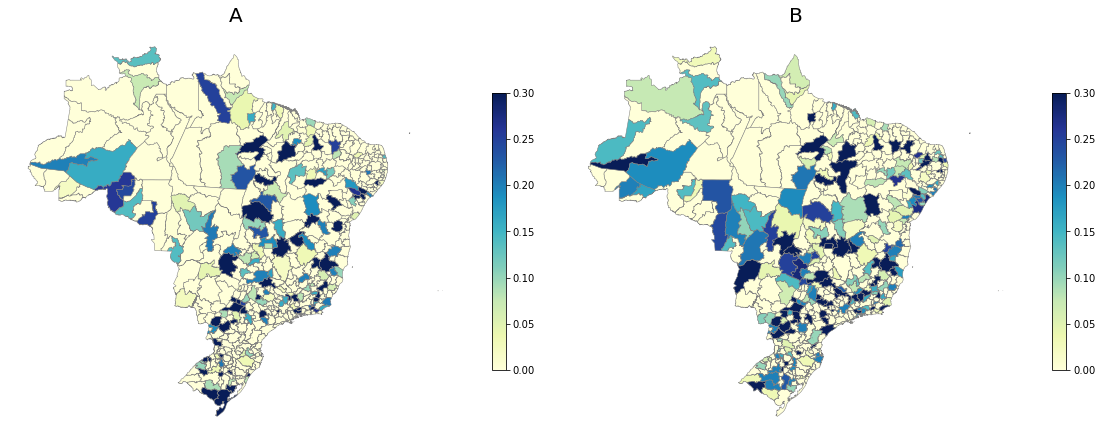

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first map - APS incidence with clipped color scale
gdf.plot(column='anticipation_score_aps',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[0],
         edgecolor='gray',
         legend=True,
         #vmax=43704.755618,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )
         
        
ax[0].set_title('A', fontsize=20)
ax[0].axis('off')

# Plot the second map - OTC incidence with clipped color scale
gdf.plot(column='anticipation_score_otc',
         cmap='YlGnBu',
         linewidth=0.5,
         ax=ax[1],
         edgecolor='gray',
         legend=True,
         #vmax=2.872972e+05,
         legend_kwds={'shrink': 0.5}  # Shrinks the colorbar (0.5 = half the default size)
         )

ax[1].set_title('B', fontsize=20)
ax[1].axis('off')



# Adjust spacing
plt.tight_layout()

#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.png', dpi=300, bbox_inches='tight')
#plt.savefig('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/map_aih_otc_aps.pdf', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


In [76]:
gdf.anticipation_score_aps.describe()

count    510.000000
mean       0.054445
std        0.099574
min        0.000000
25%        0.000000
50%        0.000000
75%        0.060000
max        0.300000
Name: anticipation_score_aps, dtype: float64

In [77]:
gdf.anticipation_score_otc.describe()

count    510.000000
mean       0.079972
std        0.109639
min        0.000000
25%        0.000000
50%        0.000000
75%        0.160000
max        0.300000
Name: anticipation_score_otc, dtype: float64

In [115]:
# Define percentile-based thresholds
threshold = 0.05  # You can adjust this

def categorize_region(row):
    if row["anticipation_score_otc"] >= threshold and row["anticipation_score_aps"] >= threshold:
        return "Both good"
    elif row["anticipation_score_otc"] >= threshold:
        return "OTC better"
    elif row["anticipation_score_aps"] >= threshold:
        return "PHC better"
    else:
        return "Both bad"

# Apply function to create the category column
gdf["anticipation_category"] = gdf.apply(categorize_region, axis=1)


In [116]:
# Print summary
round(gdf["anticipation_category"].value_counts()*100/510,1)

Both bad      52.4
OTC better    22.0
Both good     17.1
PHC better     8.6
Name: anticipation_category, dtype: float64

In [117]:
gdf[gdf["anticipation_category"] == 'Both bad'][['anticipation_score_otc','anticipation_score_aps','anticipation_category']]

,anticipation_score_otc,anticipation_score_aps,anticipation_category
2,0.031429,0.0,Both bad
4,0.000000,0.0,Both bad
7,0.000000,0.0,Both bad
9,0.000000,0.0,Both bad
10,0.000000,0.0,Both bad
...,...,...,...
494,0.000000,0.0,Both bad
499,0.000000,0.0,Both bad
504,0.028000,0.0,Both bad
505,0.000000,0.0,Both bad


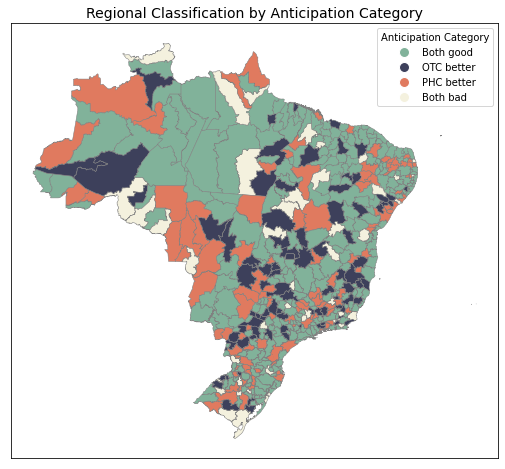

In [118]:
# Define a color mapping for categories
category_colors = {
    "Both good": "#81B29A",  # muted sage green 
    "OTC better": "#3D405B",  # deep slate blue 
    "PHC better": "#E07A5F",  # terra cotta 
    "Both bad": "#F4F1DE"  # antique white
}


# Ensure 'anticipation_category' is categorical
gdf["anticipation_category"] = gdf["anticipation_category"].astype("category")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the regions based on the category
gdf.plot(column="anticipation_category",
         cmap=mcolors.ListedColormap(category_colors.values()),  
         linewidth=0.5,
         ax=ax,
         edgecolor="gray",
         legend=False)  # We'll add a custom legend instead

# Add a custom legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markersize=10,
                       markerfacecolor=category_colors[cat], label=cat) for cat in category_colors]

ax.legend(handles=handles, title="Anticipation Category", loc="upper right")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Regional Classification by Anticipation Category", fontsize=14)

# Show plot
plt.show()


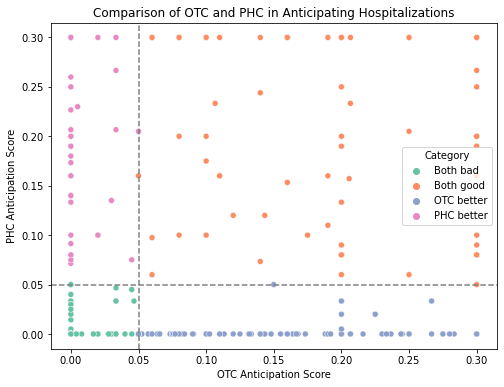

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=gdf, x="anticipation_score_otc", y="anticipation_score_aps", hue="anticipation_category", palette="Set2")

plt.axhline(threshold, color="gray", linestyle="--")
plt.axvline(threshold, color="gray", linestyle="--")

plt.xlabel("OTC Anticipation Score")
plt.ylabel("PHC Anticipation Score")
plt.title("Comparison of OTC and PHC in Anticipating Hospitalizations")
plt.legend(title="Category")
plt.show()


In [120]:
gdf["precision_otc"] = (gdf["n3_otc"] + gdf["n2_otc"] + gdf["n1_otc"] + gdf["n0_otc"] + gdf["n1_after_otc"]) / (
    gdf["n3_otc"] + gdf["n2_otc"] + gdf["n1_otc"] + gdf["n0_otc"] + gdf["n1_after_otc"] + gdf["missed_otc"]
)

gdf["recall_otc"] = (gdf["n3_otc"] + gdf["n2_otc"] + gdf["n1_otc"] + gdf["n0_otc"] + gdf["n1_after_otc"]) / gdf["total_aih_warning_otc"]

gdf["f1_score_otc"] = 2 * (gdf["precision_otc"] * gdf["recall_otc"]) / (gdf["precision_otc"] + gdf["recall_otc"])
gdf["f1_score_otc"] = gdf["f1_score_otc"].fillna(0)  # Handle division by zero



In [121]:
gdf["precision_aps"] = (gdf["n3"] + gdf["n2"] + gdf["n1"] + gdf["n0"] + gdf["n1_after"]) / (
    gdf["n3"] + gdf["n2"] + gdf["n1"] + gdf["n0"] + gdf["n1_after"] + gdf["missed"]
)

gdf["recall_aps"] = (gdf["n3"] + gdf["n2"] + gdf["n1"] + gdf["n0"] + gdf["n1_after"]) / gdf["total_aih_warning_otc"]

gdf["f1_score_aps"] = 2 * (gdf["precision_aps"] * gdf["recall_aps"]) / (gdf["precision_aps"] + gdf["recall_aps"])
gdf["f1_score_aps"] = gdf["f1_score_aps"].fillna(0)  # Handle division by zero



In [122]:
gdf["precision_aps"].describe()

count    431.000000
mean       0.559956
std        0.353302
min        0.000000
25%        0.333333
50%        0.500000
75%        1.000000
max        1.000000
Name: precision_aps, dtype: float64

In [123]:
# Define thresholds: You can use median, mean, or fixed cutoffs (e.g., 0.5)
precision_threshold_phc = gdf["precision_aps"].median()
recall_threshold_phc = gdf["recall_aps"].median()
f1_threshold_phc = gdf["f1_score_aps"].median()

precision_threshold_otc = gdf["precision_otc"].median()
recall_threshold_otc = gdf["recall_otc"].median()
f1_threshold_otc = gdf["f1_score_otc"].median()

# Function to assign categories
def categorize_performance(row):
    if (row["precision_aps"] >= precision_threshold_phc and row["recall_aps"] >= recall_threshold_phc and row["f1_score_aps"] >= f1_threshold_phc) and \
       (row["precision_otc"] >= precision_threshold_otc and row["recall_otc"] >= recall_threshold_otc and row["f1_score_otc"] >= f1_threshold_otc):
        return "Both good"
    
    elif (row["precision_aps"] >= precision_threshold_phc and row["recall_aps"] >= recall_threshold_phc and row["f1_score_aps"] >= f1_threshold_phc) and \
         (row["precision_otc"] < precision_threshold_otc or row["recall_otc"] < recall_threshold_otc or row["f1_score_otc"] < f1_threshold_otc):
        return "PHC better"
    
    elif (row["precision_otc"] >= precision_threshold_otc and row["recall_otc"] >= recall_threshold_otc and row["f1_score_otc"] >= f1_threshold_otc) and \
         (row["precision_aps"] < precision_threshold_phc or row["recall_aps"] < recall_threshold_phc or row["f1_score_aps"] < f1_threshold_phc):
        return "OTC better"
    
    else:
        return "Both bad"

# Apply the function
gdf["anticipation_category2"] = gdf.apply(categorize_performance, axis=1)


In [128]:
round(gdf["anticipation_category2"].value_counts()*100/510,1)

Both bad      34.1
Both good     32.4
PHC better    20.8
OTC better    12.7
Name: anticipation_category2, dtype: float64

In [126]:
# Print summary
gdf["anticipation_category"].value_counts()

Both bad      267
OTC better    112
Both good      87
PHC better     44
Name: anticipation_category, dtype: int64

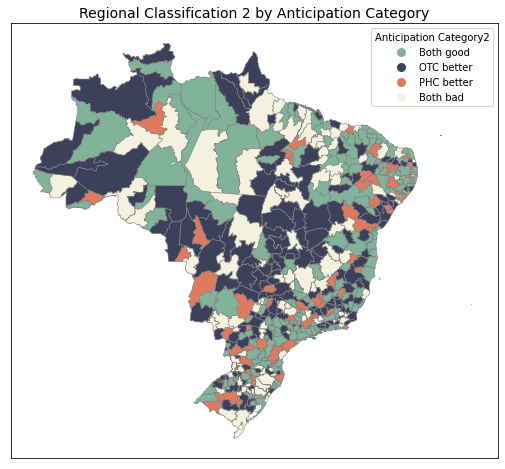

In [127]:
# Define a color mapping for categories
category_colors = {
    "Both good": "#81B29A",  # muted sage green 
    "OTC better": "#3D405B",  # deep slate blue 
    "PHC better": "#E07A5F",  # terra cotta 
    "Both bad": "#F4F1DE"  # antique white
}


# Ensure 'anticipation_category' is categorical
gdf["anticipation_category2"] = gdf["anticipation_category2"].astype("category")

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the regions based on the category
gdf.plot(column="anticipation_category2",
         cmap=mcolors.ListedColormap(category_colors.values()),  
         linewidth=0.5,
         ax=ax,
         edgecolor="gray",
         legend=False)  # We'll add a custom legend instead

# Add a custom legend
handles = [plt.Line2D([0], [0], marker="o", color="w", markersize=10,
                       markerfacecolor=category_colors[cat], label=cat) for cat in category_colors]

ax.legend(handles=handles, title="Anticipation Category2", loc="upper right")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Regional Classification 2 by Anticipation Category", fontsize=14)

# Show plot
plt.show()


In [130]:
gdf.columns

Index(['rgi', 'nome_rgi', 'geometry', 'co_imed', 'pseudo_R2', 'conf_int',
       'log_likelihood', 'deviance', 'pearson_chi2', 'corre_forecasted',
       'p_value_corr_forecast', 'Intercept', 'aih_4_lag_1', 'phc_4_lag_0',
       'phc_4_lag_1', 'time_trend', 'Reconstructed', 'n3_otc', 'n2_otc',
       'n1_otc', 'n0_otc', 'n1_after_otc', 'missed_otc',
       'total_aih_warning_otc', 'n3', 'n2', 'n1', 'n0', 'n1_after', 'missed',
       'anticipation_score_otc', 'anticipation_score_aps',
       'anticipation_category', 'precision', 'recall', 'f1_score',
       'precision_otc', 'recall_otc', 'f1_score_otc', 'precision_aps',
       'recall_aps', 'f1_score_aps', 'anticipation_category2'],
      dtype='object')

In [ ]:
Pode tb usar acuracia como VP+VN/VP+VN+FP+FN